# Train Classifier For News Classification
> ## * Word2Vec

In [1]:
import pickle
import html
import multiprocessing
from collections import namedtuple, OrderedDict
import re
import sys
import os
from glob import glob

from numba import jit

os.environ['KERAS_BACKEND']='tensorflow'

import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import pandas as pd

from gensim.models import Word2Vec, KeyedVectors
from gensim.models.doc2vec import TaggedDocument

from konlpy.utils import pprint

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve,  accuracy_score, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import scale, MinMaxScaler, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.multiclass import OneVsRestClassifier

import keras.backend.tensorflow_backend as K
from keras.preprocessing import sequence
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.layers import Input, Flatten, Dense, Embedding, embeddings, merge, Dropout, Activation,  LSTM, Bidirectional, SimpleRNN, GRU
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout1D
from keras.utils import np_utils
from tensorflow.python.client import device_lib
from keras.layers.merge import dot

import xgboost as xgb

import matplotlib.pyplot as plt


import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17621844402533053948
]


In [3]:
import Basic_Module as bm

In [4]:
cores = multiprocessing.cpu_count()
print (cores)

4


## Document Labeling

In [5]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags category')

> * words : 기사에서 나온 단어들 or keywords
> * tags : 문서 tag
> * classes : category
>> 기사분류가 daum보다 naver에서 더 세분화되어 있기 때문에 네이버의 category 분류를 이용하기로 함

## Category

In [6]:
if os.path.isfile('./data/pre_data/news_tagged_data/pre_data_category_label_encoder_by_ct_for_word2vec_news_classification.pickled'):
    le = pickle.load(open('./data/pre_data/news_tagged_data/pre_data_category_label_encoder_by_ct_for_word2vec_news_classification.pickled','rb'))
else:
    le = LabelEncoder()
    le.fit(naverData['category'])
    pickle.dump(le, open('./data/pre_data/news_tagged_data/pre_data_category_label_encoder_by_ct_for_word2vec_news_classification.pickled','wb'))
print (le.classes_)

['IT/과학' '경제' '사회' '생활/문화' '세계' '스포츠' '연예' '정치']


In [7]:
if sys.platform =='darwin':
    loadModelPath = './news_model/'
elif sys.platform =='win32':
    loadModelPath = 'd:/news_model/'
saveTrainPath = './data/pre_data/news_train_test_Data2/'
saveClassifierPath = './data/pre_data/news_classifier/'

## Tagging Twitter

> 전 단계에서 필요한 사전 데이터는 만들어 둠

### Train Data Set & Test Data Set

In [8]:
trainName = './data/pre_data/news_train_test_Data/pre_data_word2vec_train_for_news_classification_by_ct.pickled'
testName = './data/pre_data/news_train_test_Data/pre_data_word2vec_test_for_news_classification_by_ct.pickled'

In [9]:
if os.path.isfile(trainName) & os.path.isfile(testName):
    train = pickle.load(open(trainName, 'rb'))
    test = pickle.load(open(testName, 'rb'))
else:
    train, test = train_test_split(w2v_docs, test_size = 0.15)
    pickle.dump(train,open(trainName,'wb'))
    pickle.dump(test,open(testName,'wb'))

### train set을 사용하여 Tf-Idf vectorizer을 만듦

In [10]:
tfidf = bm.Build_tfidf(train)

100%|██████████| 12852/12852 [00:00<00:00, 769491.60it/s]


(12852, 73763)
vocab size : 73763


In [11]:
x_train = [ x.words for x in tqdm(train)] 
y_train = np.array([ x.category for x in tqdm(train)])
x_test = [ x.words for x in tqdm(test)] 
y_test = np.array([ x.category for x in tqdm(test)])

100%|██████████| 2268/2268 [00:00<00:00, 851018.20it/s]


In [12]:
train_y2, test_y2 = bm.ReMake_Outcome(y_train, y_test)

100%|██████████| 2268/2268 [00:00<00:00, 723452.85it/s]


### Load Model

In [13]:
model1 = Word2Vec.load(loadModelPath+'word2vec_size-500_epoch-20_window-10_negative-7_hs-0_sg-0_cbow_mean-0_min_count-2_by-ct.model')
model2 = Word2Vec.load(loadModelPath+'word2vec_size-500_epoch-20_window-10_negative-7_hs-0_sg-0_cbow_mean-1_min_count-2_by-ct.model')
model3 = Word2Vec.load(loadModelPath+'word2vec_size-500_epoch-20_window-10_negative-7_hs-0_sg-1_cbow_mean-0_min_count-2_by-ct.model')

### model 1

In [14]:
wv1, train_vecs_w2v, test_vecs_w2v = bm.Make_Pre_Data(model1, tfidf, 500, train, test)
modelName = bm.Return_ModelName('word2vec', model1,'ct')

 28%|██▊       | 22317/80534 [00:00<00:00, 111564.89it/s]

Word2Vec(vocab=80534, size=500, alpha=0.025)


100%|██████████| 80534/80534 [00:00<00:00, 99925.65it/s] 
7it [00:00, 62.31it/s]

running time : 0:00:00.811046
Vectorizing Train Data


12852it [04:30, 47.53it/s]


scaling Train Data


4it [00:00, 35.02it/s]

running time : 0:04:31.239537
Vectorizing Test Data


2268it [00:52, 43.04it/s]


scaling Test Data
running time : 0:00:52.782001
total running time : 0:05:24.832584


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [15]:
%%time
bm.Make_TSNE2(2, model1, wv1, 10000)

Loading BokehJS ...

100%|██████████| 10000/10000 [00:00<00:00, 48603.13it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.875s...
[t-SNE] Computed neighbors for 10000 samples in 221.331s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.136822
[t-SNE] KL divergence after 250 iterations with early exaggeration: 152.429779
[t-SNE] Error after 1000 iterations: 4.408333


CPU times: user 12min 52s, sys: 43.1 s, total: 13min 35s
Wall time: 18min 16s


#### 분류모델 :  Logistic Regression

In [16]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 4, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.8871252204585538
classification report
             precision    recall  f1-score   support

          0       0.86      0.89      0.87       281
          1       0.89      0.81      0.85       291
          2       0.79      0.82      0.80       248
          3       0.84      0.85      0.84       299
          4       0.86      0.85      0.85       282
          5       0.99      0.98      0.99       296
          6       0.98      0.97      0.98       284
          7       0.88      0.91      0.90       287

avg / total       0.89      0.89      0.89      2268

CPU times: user 56.2 s, sys: 834 ms, total: 57 s
Wall time: 1min 4s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

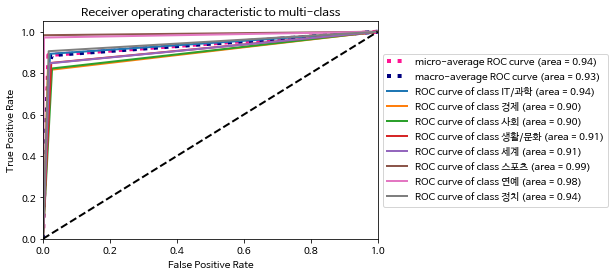

In [17]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

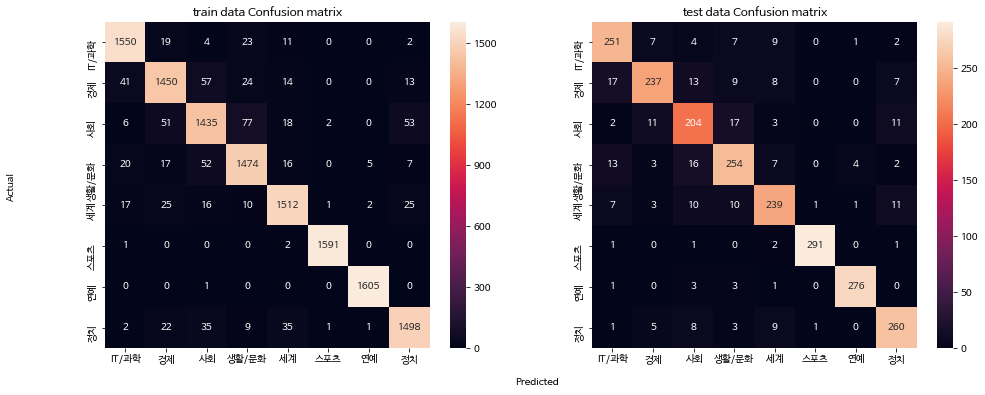

In [18]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier, le)

#### 분류모델 : Random Forest Classifier

In [19]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 4, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.8910934744268078
classification report
             precision    recall  f1-score   support

          0       0.87      0.92      0.90       281
          1       0.86      0.85      0.86       291
          2       0.78      0.82      0.80       248
          3       0.88      0.84      0.86       299
          4       0.87      0.86      0.86       282
          5       1.00      0.97      0.98       296
          6       0.95      0.96      0.96       284
          7       0.90      0.90      0.90       287

avg / total       0.89      0.89      0.89      2268

CPU times: user 32.7 s, sys: 258 ms, tot

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

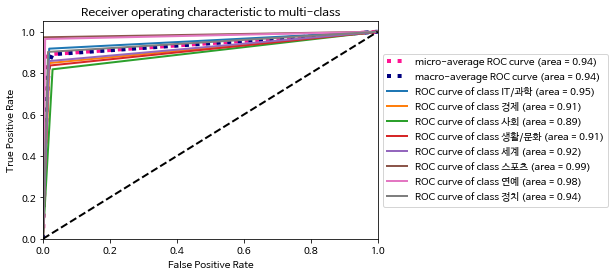

In [20]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier2, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

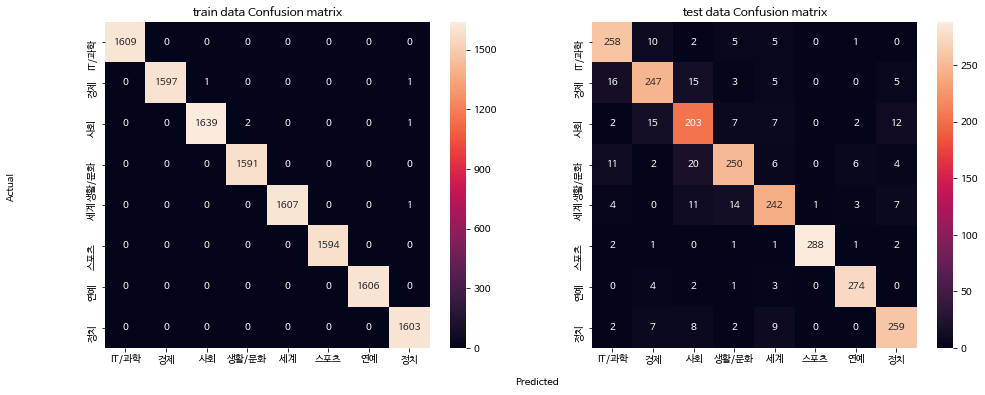

In [21]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [22]:
%%time
classifier3 =  SVC(kernel = 'rbf',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.9140211640211641
classification report
             precision    recall  f1-score   support

          0       0.90      0.95      0.92       281
          1       0.90      0.85      0.87       291
          2       0.85      0.85      0.85       248
          3       0.91      0.90      0.90       299
          4       0.88      0.89      0.88       282
          5       0.99      0.98      0.98       296
          6       0.97      0.97      0.97       284
          7       0.91      0.92      0.91       287

avg / total       0.91      0.91      0.91      2268

CPU times: user 1min 2s, sys: 737 ms, total: 1min 2s
Wall time: 1min 9s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

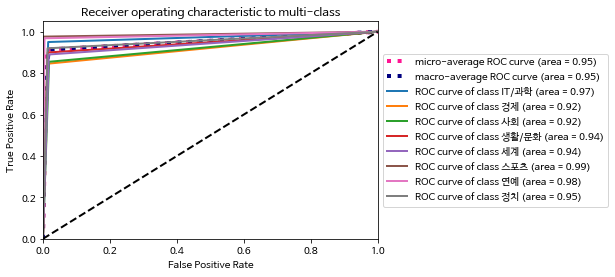

In [23]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier3, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

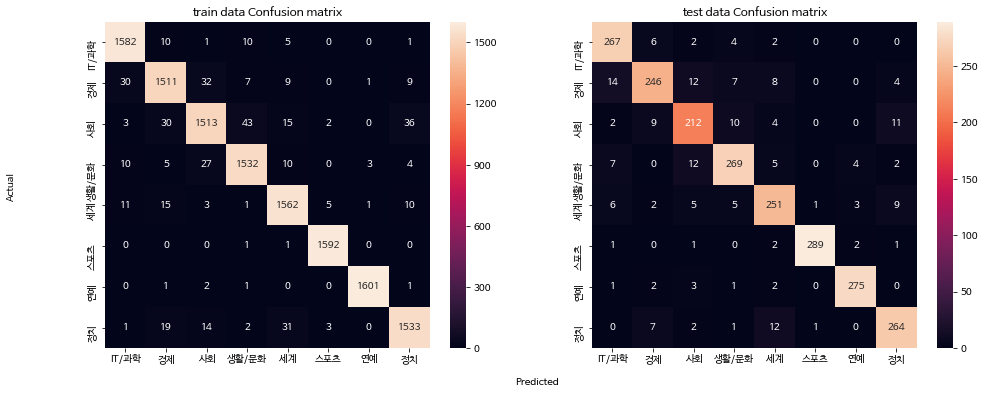

In [24]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier3, le)

#### 분류모델 : XGBoost

In [25]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

CPU times: user 49.9 ms, sys: 32.2 ms, total: 82 ms
Wall time: 79 ms


In [26]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-mlogloss:1.76623	eval-mlogloss:1.7952
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.55172	eval-mlogloss:1.61153
[2]	train-mlogloss:1.37936	eval-mlogloss:1.46122
[3]	train-mlogloss:1.24465	eval-mlogloss:1.33939
[4]	train-mlogloss:1.12828	eval-mlogloss:1.23358
[5]	train-mlogloss:1.02974	eval-mlogloss:1.14621
[6]	train-mlogloss:0.944139	eval-mlogloss:1.06909
[7]	train-mlogloss:0.867353	eval-mlogloss:1.00118
[8]	train-mlogloss:0.800468	eval-mlogloss:0.94256
[9]	train-mlogloss:0.742139	eval-mlogloss:0.890882
[10]	train-mlogloss:0.689143	eval-mlogloss:0.84552
[11]	train-mlogloss:0.641963	eval-mlogloss:0.803427
[12]	train-mlogloss:0.599938	eval-mlogloss:0.76579
[13]	train-mlogloss:0.560574	eval-mlogloss:0.732191
[14]	train-mlogloss:0.525009	eval-mlogloss:0.70131
[15]	train-mlogloss:0.494286	eval-mlogloss:0.673907
[16]	train-mlogloss:0.465705	eval-mlogloss:0.6

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

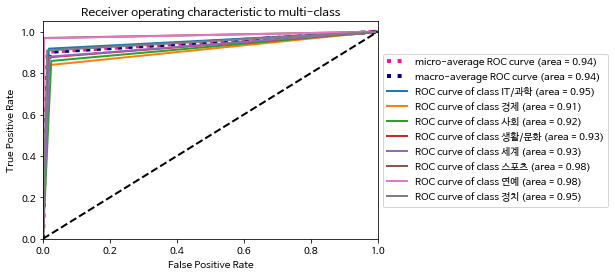

In [27]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

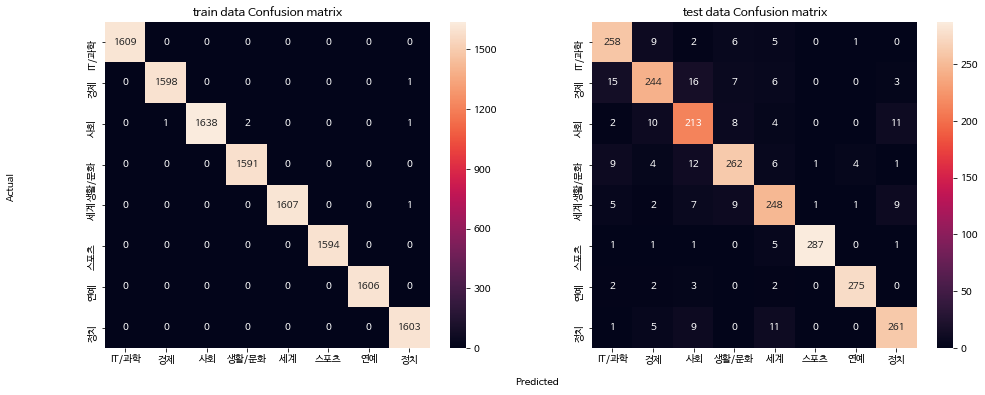

In [28]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)

In [29]:
del classifier
del classifier2
del classifier3
del gbm

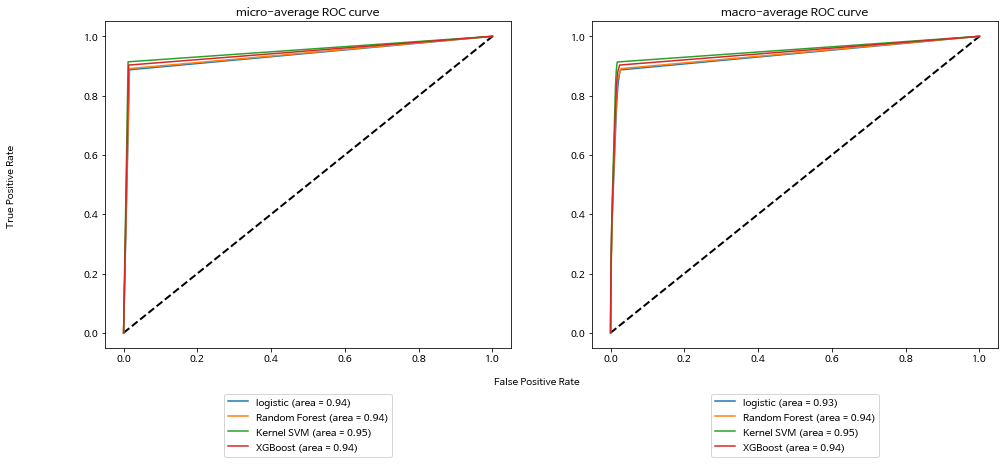

In [30]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델  : Neural Network

In [31]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [32]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.5225
Accuracy: 0.8907


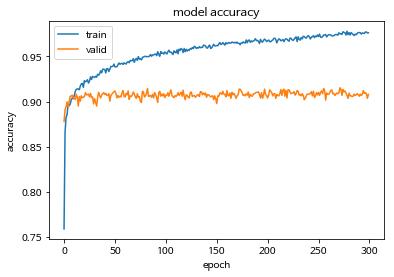

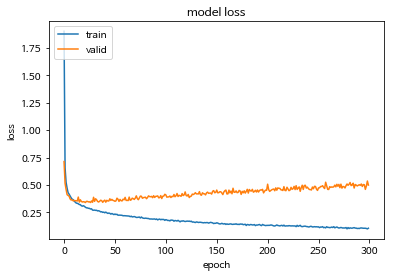

In [33]:
bm.plot_history(history)

In [34]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))


Score: 0.8517
Accuracy: 0.8854


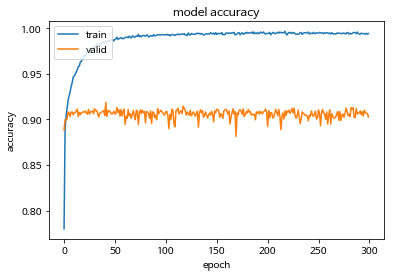

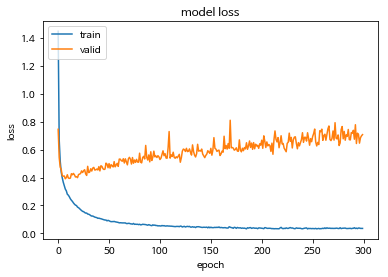

In [35]:
bm.plot_history(history)

### model 2

In [36]:
wv1, train_vecs_w2v, test_vecs_w2v = bm.Make_Pre_Data(model2, tfidf, 500, train, test)
modelName = bm.Return_ModelName('word2vec', model2,'ct')

 10%|▉         | 7831/80534 [00:00<00:00, 78289.54it/s]

Word2Vec(vocab=80534, size=500, alpha=0.025)


100%|██████████| 80534/80534 [00:01<00:00, 77366.61it/s]
1it [00:00,  7.34it/s]

running time : 0:00:01.047385
Vectorizing Train Data


12852it [03:20, 64.05it/s]


scaling Train Data


6it [00:00, 44.77it/s]

running time : 0:03:21.008268
Vectorizing Test Data


2268it [00:34, 66.26it/s]


scaling Test Data
running time : 0:00:34.283944
total running time : 0:03:56.339597


#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [37]:
%%time
bm.Make_TSNE2(2, model2, wv1, 10000)

Loading BokehJS ...

100%|██████████| 10000/10000 [00:00<00:00, 107956.49it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.641s...
[t-SNE] Computed neighbors for 10000 samples in 115.591s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.293128
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.645073
[t-SNE] Error after 1000 iterations: 2.821577


CPU times: user 9min 28s, sys: 52.1 s, total: 10min 20s
Wall time: 10min 9s


#### 분류모델 :  Logistic Regression

In [38]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'multi_class': 'ovr', 'n_jobs': 4, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.9034391534391535
classification report
             precision    recall  f1-score   support

          0       0.91      0.92      0.92       281
          1       0.88      0.83      0.86       291
          2       0.83      0.84      0.83       248
          3       0.89      0.87      0.88       299
          4       0.86      0.87      0.87       282
          5       0.99      0.98      0.98       296
          6       0.97      0.98      0.97       284
          7       0.89      0.92      0.91       287

avg / total       0.90      0.90      0.90      2268

CPU times: user 1min 5s, sys: 249 ms, total: 1min 5s
Wall time: 1min 40s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

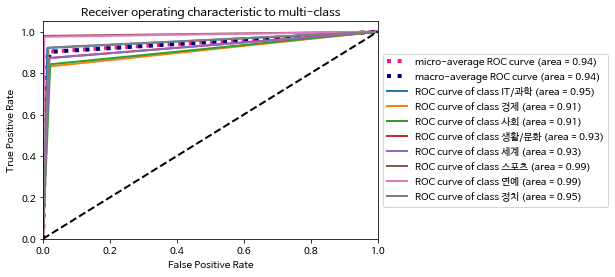

In [39]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

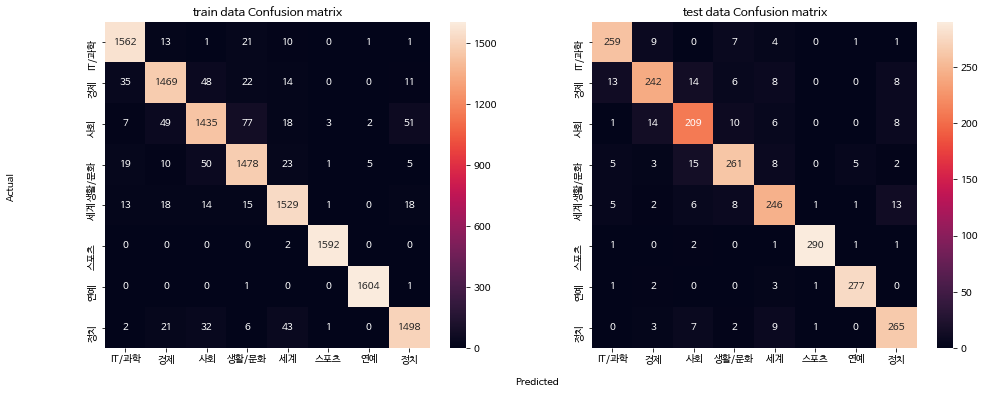

In [40]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier, le)

#### 분류모델 : Random Forest Classifier

In [41]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': 4, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
score : 0.9091710758377425
classification report
             precision    recall  f1-score   support

          0       0.89      0.94      0.92       281
          1       0.88      0.87      0.88       291
          2       0.84      0.83      0.84       248
          3       0.91      0.85      0.88       299
          4       0.88      0.89      0.89       282
          5       1.00      0.98      0.99       296
          6       0.96      0.98      0.97       284
          7       0.91      0.92      0.91       287

avg / total       0.91      0.91      0.91      2268

CPU times: user 35.5 s, sys: 232 ms, tot

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

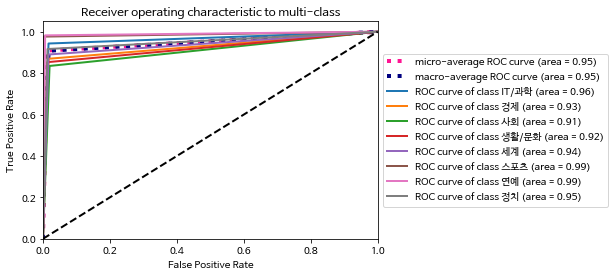

In [42]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier2, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

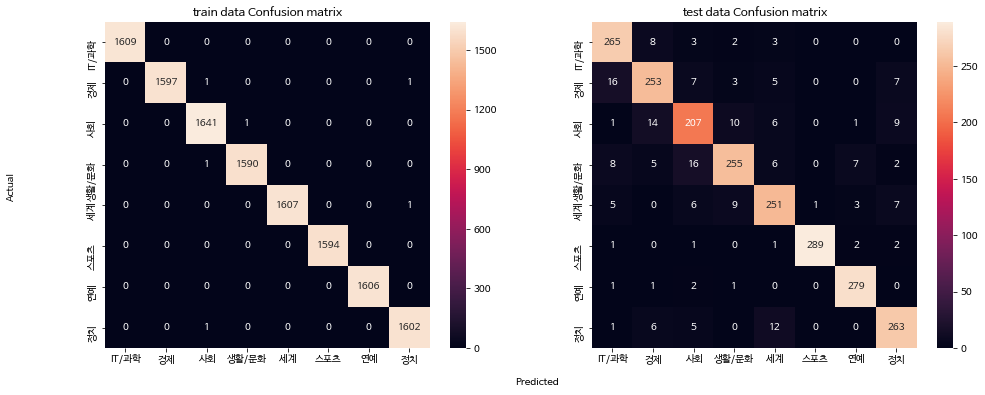

In [43]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [44]:
%%time
classifier3 =  SVC(kernel = 'rbf',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

[LibSVM]{'C': 1.0, 'cache_size': 1024, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1500, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}
score : 0.9184303350970018
classification report
             precision    recall  f1-score   support

          0       0.90      0.94      0.92       281
          1       0.91      0.87      0.89       291
          2       0.86      0.84      0.85       248
          3       0.89      0.91      0.90       299
          4       0.90      0.89      0.89       282
          5       0.99      0.99      0.99       296
          6       0.98      0.97      0.97       284
          7       0.90      0.93      0.91       287

avg / total       0.92      0.92      0.92      2268

CPU times: user 42.9 s, sys: 217 ms, total: 43.2 s
Wall time: 58.2 s


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

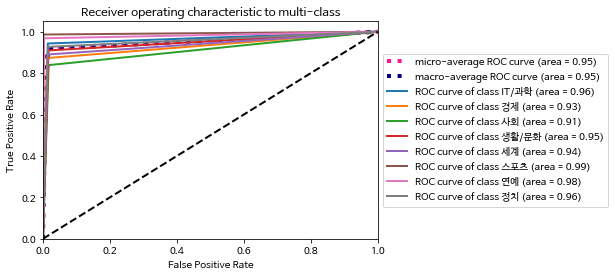

In [45]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier3, le, np.unique(train_y2))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

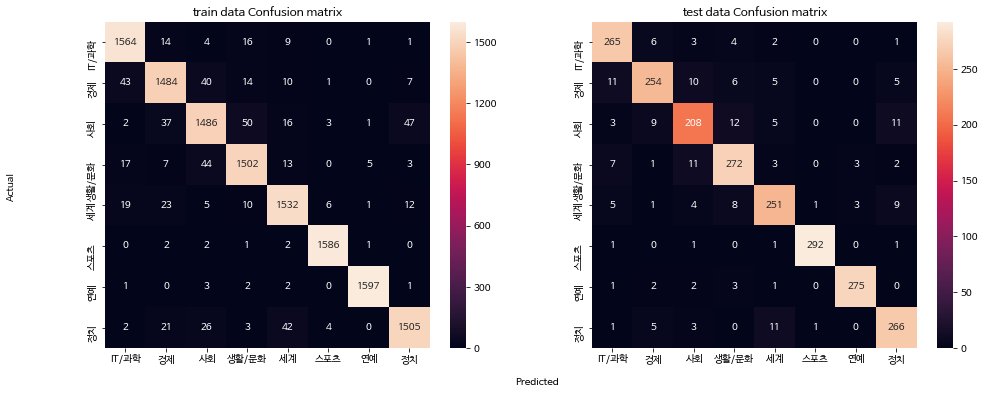

In [46]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier3, le)

#### 분류모델 : XGBoost

In [ ]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

CPU times: user 64.4 ms, sys: 37.7 ms, total: 102 ms
Wall time: 124 ms


In [ ]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

[0]	train-mlogloss:1.65216	eval-mlogloss:1.67348
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.38771	eval-mlogloss:1.42555
[2]	train-mlogloss:1.19739	eval-mlogloss:1.24737
[3]	train-mlogloss:1.04726	eval-mlogloss:1.10646
[4]	train-mlogloss:0.925271	eval-mlogloss:0.993705
[5]	train-mlogloss:0.824792	eval-mlogloss:0.90151
[6]	train-mlogloss:0.741403	eval-mlogloss:0.825664
[7]	train-mlogloss:0.669745	eval-mlogloss:0.757626
[8]	train-mlogloss:0.608167	eval-mlogloss:0.702533
[9]	train-mlogloss:0.555525	eval-mlogloss:0.656259
[10]	train-mlogloss:0.509287	eval-mlogloss:0.613658
[11]	train-mlogloss:0.469597	eval-mlogloss:0.577184
[12]	train-mlogloss:0.434264	eval-mlogloss:0.546022
[13]	train-mlogloss:0.403459	eval-mlogloss:0.517879
[14]	train-mlogloss:0.376232	eval-mlogloss:0.493257
[15]	train-mlogloss:0.351382	eval-mlogloss:0.47197
[16]	train-mlogloss:0.329394	eval-mlo

In [ ]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)

In [ ]:
del classifier
del classifier2
del classifier3
del gbm

In [ ]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델  : Neural Network

In [ ]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

In [ ]:
bm.plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

In [ ]:
bm.plot_history(history)

#### model 3

In [ ]:
wv1, train_vecs_w2v, test_vecs_w2v = bm.Make_Pre_Data(model3, tfidf, 500, train, test)
modelName = bm.Return_ModelName('word2vec', model3,'ct')

#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [ ]:
%%time
bm.Make_TSNE2(2, model3, wv1, 10000)

#### 분류모델 :  Logistic Regression

In [ ]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

In [ ]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier, le)

#### 분류모델 : Random Forest Classifier

In [ ]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

In [ ]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier2, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [ ]:
%%time
classifier3 =  SVC(kernel = 'rbf',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

In [ ]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier3, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier3, le)

#### 분류모델 : XGBoost

In [ ]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [ ]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

In [ ]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)

In [ ]:
del classifier
del classifier2
del classifier3
del gbm

In [ ]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델  : Neural Network

In [ ]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

In [ ]:
bm.plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

In [ ]:
bm.plot_history(history)

## Tagging Mecab

> 전 단계에서 필요한 사전 데이터는 만들어 둠

### Train Data Set & Test Data Set

In [ ]:
trainName = './data/pre_data/news_train_test_Data/pre_data_word2vec_train_for_news_classification_by_mecab.pickled'
testName = './data/pre_data/news_train_test_Data/pre_data_word2vec_test_for_news_classification_by_mecab.pickled'

In [ ]:
if os.path.isfile(trainName) & os.path.isfile(testName):
    train = pickle.load(open(trainName, 'rb'))
    test = pickle.load(open(testName, 'rb'))
else:
    train, test = train_test_split(w2v_docs, test_size = 0.15)
    pickle.dump(train,open(trainName,'wb'))
    pickle.dump(test,open(testName,'wb'))

### train set을 사용하여 Tf-Idf vectorizer을 만듦

In [ ]:
tfidf = bm.Build_tfidf(train)

In [ ]:
x_train = [ x.words for x in tqdm(train)] 
y_train = np.array([ x.category for x in tqdm(train)])
x_test = [ x.words for x in tqdm(test)] 
y_test = np.array([ x.category for x in tqdm(test)])

In [ ]:
train_y2, test_y2 = bm.ReMake_Outcome(y_train, y_test)

### Load Model

In [ ]:
model1 = Word2Vec.load(loadModelPath+'word2vec_size-500_epoch-20_window-10_negative-7_hs-0_sg-0_cbow_mean-0_min_count-2_by-mecab.model')
model2 = Word2Vec.load(loadModelPath+'word2vec_size-500_epoch-20_window-10_negative-7_hs-0_sg-0_cbow_mean-1_min_count-2_by-mecab.model')
model3 = Word2Vec.load(loadModelPath+'word2vec_size-500_epoch-20_window-10_negative-7_hs-0_sg-1_cbow_mean-0_min_count-2_by-mecab.model')

### model 1

In [ ]:
wv1, train_vecs_w2v, test_vecs_w2v = bm.Make_Pre_Data(model1, tfidf, 500, train, test)
modelName = bm.Return_ModelName('word2vec', model1,'mecab')

#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [ ]:
%%time
bm.Make_TSNE2(2, model1, wv1, 10000)

#### 분류모델 :  Logistic Regression

In [ ]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

In [ ]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier, le)

#### 분류모델 : Random Forest Classifier

In [ ]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

In [ ]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier2, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [ ]:
%%time
classifier3 =  SVC(kernel = 'rbf',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

In [ ]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier3, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier3, le)

#### 분류모델 : XGBoost

In [ ]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [ ]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

In [ ]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)

In [ ]:
del classifier
del classifier2
del classifier3
del gbm

In [ ]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델  : Neural Network

In [ ]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

In [ ]:
bm.plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

In [ ]:
bm.plot_history(history)

### model 2

In [ ]:
wv1, train_vecs_w2v, test_vecs_w2v = bm.Make_Pre_Data(model2, tfidf, 500, train, test)
modelName = bm.Return_ModelName('word2vec', model2,'mecab')

#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [ ]:
%%time
bm.Make_TSNE2(2, model2, wv1, 10000)

#### 분류모델 :  Logistic Regression

In [ ]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

In [ ]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier, le)

#### 분류모델 : Random Forest Classifier

In [ ]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

In [ ]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier2, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [ ]:
%%time
classifier3 =  SVC(kernel = 'rbf',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

In [ ]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier3, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier3, le)

#### 분류모델 : XGBoost

In [ ]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [ ]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

In [ ]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)

In [ ]:
del classifier
del classifier2
del classifier3
del gbm

In [ ]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델  : Neural Network

In [ ]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

In [ ]:
bm.plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

In [ ]:
bm.plot_history(history)

#### model 3

In [ ]:
wv1, train_vecs_w2v, test_vecs_w2v = bm.Make_Pre_Data(model3, tfidf, 500, train, test)
modelName = bm.Return_ModelName('word2vec', model3,'mecab')

#### t-SNE
> * t-분포 확률적 임베딩
> * 데이터의 차원 축소에 사용되는 기계 학습 알고리즘
> * 비선형 차원 축소 기법으로 고차원 데이터를 특히 2, 3차원 등으로 줄여 가시화하는데에 유용하게 사용
> * 비슷한 데이터는 근접한 2, 3차원의 지점으로, 다른 데이터는 멀리 떨어진 지점으로 맵핑
##### word : 10000

In [ ]:
%%time
bm.Make_TSNE2(2, model3, wv1, 10000)

#### 분류모델 :  Logistic Regression

In [ ]:
%%time
classifier = LogisticRegression(max_iter = 250, n_jobs = cores)
classifier.fit(train_vecs_w2v, train_y2)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier.predict(test_vecs_w2v)))
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+modelName, 'wb'))

In [ ]:
roc_auc_out1 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier, le)

#### 분류모델 : Random Forest Classifier

In [ ]:
%%time
classifier2 = RandomForestClassifier(n_estimators = 75, n_jobs = cores)
classifier2.fit(train_vecs_w2v, train_y2)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier2.predict(test_vecs_w2v)))
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+modelName, 'wb'))

In [ ]:
roc_auc_out2 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier2, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier2, le)

#### 분류모델 : C-Support Vector Classification

In [ ]:
%%time
classifier3 =  SVC(kernel = 'rbf',
        cache_size= 1024, max_iter = 1500, verbose = True) 
classifier3.fit(train_vecs_w2v, train_y2)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_vecs_w2v, test_y2)))
print ('classification report')
print (classification_report(test_y2, classifier3.predict(test_vecs_w2v)))
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+modelName, 'wb'))

In [ ]:
roc_auc_out3 = bm.Roc_Curve_MultiClass(test_vecs_w2v, test_y2, classifier3, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(train_vecs_w2v, train_y2, test_vecs_w2v, test_y2, classifier3, le)

#### 분류모델 : XGBoost

In [ ]:
%%time
dtrain = xgb.DMatrix(train_vecs_w2v, y_train)
dvalid = xgb.DMatrix(test_vecs_w2v, y_test)

In [ ]:
%%time
max_depth = 5
subsample = 0.7
colsample_bytree = 0.7
params = {
    'objective' : 'multi:softmax', 
    'booster' : 'gbtree',
    'max_depth' : max_depth, 
    'subsample' : subsample,
    #'eval_metric' : 'auc', 
    'eval_metric' : 'mlogloss',
    'colsample_bytree' : colsample_bytree,
    'silent' : 1, 
    'eta' : 0.175,
    'nthread' : cores,
    'num_class' : 8
}
num_boost_round = 200
early_stopping_rounds = 10
test_size = 0.15

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals = watchlist,
                early_stopping_rounds = early_stopping_rounds, verbose_eval = True)

test_prediction = gbm.predict(xgb.DMatrix(test_vecs_w2v))
test_acc = accuracy_score(y_test, test_prediction)
print (test_acc)
gbm.save_model(saveClassifierPath+'XGBoost_'+modelName)

In [ ]:
roc_auc_out4 = bm.Roc_Curve_MultiClass(xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le, np.unique(train_y2))

In [ ]:
bm.ConfusionMatrix_To_Heatmap(xgb.DMatrix(train_vecs_w2v), train_y2, xgb.DMatrix(test_vecs_w2v), test_y2, gbm, le)

In [ ]:
del classifier
del classifier2
del classifier3
del gbm

In [ ]:
bm.Plot_Roc_Curver_Micro_Macro(roc_auc_out1, roc_auc_out2, roc_auc_out3, roc_auc_out4)

#### 분류모델  : Neural Network

In [ ]:
y_test2 = np_utils.to_categorical(y_test,8)
y_train2 = np_utils.to_categorical(y_train,8)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'sigmoid', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_1_'+modelName)

In [ ]:
bm.plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=500))
model.add(Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train2, epochs=300,  verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)
model.save(saveClassifierPath+'NeuralNetwork_2_'+modelName)

In [ ]:
bm.plot_history(history)